# Evolution of a fan

This notebook reproduces the [fan example](https://fastscape-lem.github.io/fastscapelib-fortran/#_fan_f90) provided in the fastscapelib-fortran library. It illustrates continental transport/deposition.

In [1]:
import numpy as np
import xsimlab as xs
import matplotlib.pyplot as plt
import fastscape

%matplotlib inline

In [2]:
print('xarray-simlab version: ', xs.__version__)
print('fastscape version: ', fastscape.__version__)

xarray-simlab version:  0.4.1
fastscape version:  0.1.0beta


## Import, customize and inspect the model

A sediment model is available in [fastscape](https://fastscape.readthedocs.io/en/latest/).

In [3]:
from fastscape.models import sediment_model

We want to model the evolution of a passive escarpment, thus with no uplift.

In [4]:
from fastscape.processes import Escarpment


model = (sediment_model
         .drop_processes('uplift')
         .update_processes({'init_topography': Escarpment}))

In [5]:
model

<xsimlab.Model (18 processes, 16 inputs)>
grid
    length                  [in] ('shape_yx',) total grid length in...
    shape                   [in] ('shape_yx',) nb. of grid nodes in...
fs_context
boundary
    status                  [in] () or ('border',) node status at b...
tectonics
init_topography
    elevation_left          [in] elevation on the left side of the ...
    elevation_right         [in] elevation on the right side of the...
    x_left                  [in] location of the scarp's left limit...
    x_right                 [in] location of the scarp's right limi...
surf2erode
flow
    slope_exp               [in] MFD partioner slope exponent
drainage
init_bedrock
active_layer
spl
    slope_exp               [in] slope exponent
    g_coef_soil             [in] soil (sediment) transport/depositi...
    g_coef_bedrock          [in] detached bedrock transport/deposit...
    k_coef_soil             [in] () or ('y', 'x') soil (sediment) c...
    k_coef_bedrock          [in]

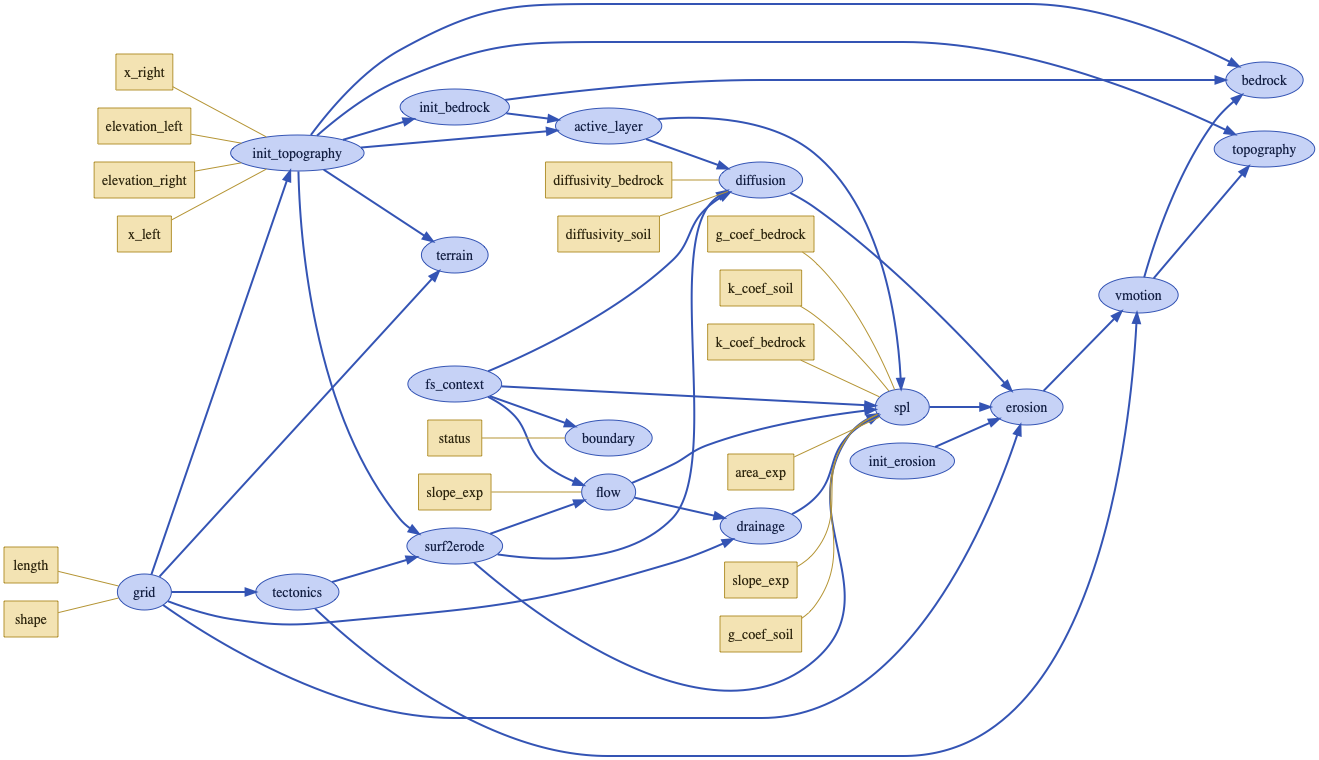

In [6]:
model.visualize(show_inputs=True)

## Model setup

In [7]:
in_ds = xs.create_setup(
    model=model,
    clocks={
        'time': np.arange(0, 4e5 + 2e3, 2e3),
        'out': np.arange(0, 4e5 + 4e3, 4e3),
    },
    master_clock='time',
    input_vars={
        'grid__shape': [101, 201],
        'grid__length': [1e4, 2e4],
        'boundary__status': ['fixed_value', 'core', 'looped', 'looped'],
        'init_topography': {
            'x_left': 1e4,
            'x_right': 1e4,
            'elevation_left': 0.,
            'elevation_right': 1e3
        },
        'flow__slope_exp': 1.,
        'spl': {
            'k_coef_bedrock': 1e-4,
            'k_coef_soil': 1.5e-4,
            'g_coef_bedrock': 1.,
            'g_coef_soil': 1.,
            'area_exp': 0.4,
            'slope_exp': 1.
        },
        'diffusion': {
            'diffusivity_bedrock': 1e-2,
            'diffusivity_soil': 1.5e-2
        }
    },
    output_vars={
        'topography__elevation': 'out',
        'erosion__rate': 'out'
    }
)

in_ds

<xarray.Dataset>
Dimensions:                           (border: 4, out: 101, shape_yx: 2, time: 201)
Coordinates:
  * time                              (time) float64 0.0 2e+03 ... 4e+05
  * out                               (out) float64 0.0 4e+03 ... 3.96e+05 4e+05
Dimensions without coordinates: border, shape_yx
Data variables:
    grid__shape                       (shape_yx) int64 101 201
    grid__length                      (shape_yx) float64 1e+04 2e+04
    boundary__status                  (border) <U11 'fixed_value' ... 'looped'
    init_topography__x_left           float64 1e+04
    init_topography__x_right          float64 1e+04
    init_topography__elevation_left   float64 0.0
    init_topography__elevation_right  float64 1e+03
    flow__slope_exp                   float64 1.0
    spl__k_coef_bedrock               float64 0.0001
    spl__k_coef_soil                  float64 0.00015
    spl__g_coef_bedrock               float64 1.0
    spl__g_coef_soil                  float

## Run the model


In [8]:
with xs.monitoring.ProgressBar():
    out_ds = in_ds.xsimlab.run(model=model)

In [9]:
out_ds

<xarray.Dataset>
Dimensions:                           (border: 4, out: 101, shape_yx: 2, time: 201, x: 201, y: 101)
Coordinates:
  * border                            (border) <U6 'left' 'right' 'top' 'bottom'
  * out                               (out) float64 0.0 4e+03 ... 3.96e+05 4e+05
  * time                              (time) float64 0.0 2e+03 ... 4e+05
  * x                                 (x) float64 0.0 100.0 ... 1.99e+04 2e+04
  * y                                 (y) float64 0.0 100.0 ... 9.9e+03 1e+04
Dimensions without coordinates: shape_yx
Data variables:
    boundary__status                  (border) <U11 'fixed_value' ... 'looped'
    diffusion__diffusivity_bedrock    float64 0.01
    diffusion__diffusivity_soil       float64 0.015
    erosion__rate                     (out, y, x) float64 0.0 ... 0.001721
    flow__slope_exp                   float64 1.0
    grid__length                      (shape_yx) float64 1e+04 2e+04
    grid__shape                       (shape_

## Plot the outputs

The following plots (total erosion/deposition rate, drainage area and topography cross-section) highlight the dynamics on the left area (depositional) and its interaction with the right area (erosional).

In [10]:
import hvplot.xarray
import holoviews as hv
from xshade import hillshade


erosion_plot = out_ds.erosion__rate.hvplot.image(
    x='x', y='y', clim=(-2.5e-3, 2.5e-3),
    cmap=plt.cm.RdYlGn_r, groupby='out'
)

hillshade_plot = hillshade(out_ds, 'out').hvplot.image(
    x='x', y='y', cmap=plt.cm.gray, alpha=0.4,
    colorbar=False, hover=False, groupby='out'
)

ysections =  out_ds.topography__elevation.sel(y=[2.5e3, 5e3, 7.5e3])

sections_plot = ysections.hvplot.line(
    by='y', groupby='out', ylim=(0, 1100),
    height=200, legend='top_left',
)

hv.Layout((erosion_plot * hillshade_plot) + sections_plot).cols(1)

:Layout
   .DynamicMap.I  :DynamicMap   [out]
      :Overlay
         .Image.I  :Image   [x,y]   (erosion__rate)
         .Image.II :Image   [x,y]   (hillshade)
   .DynamicMap.II :DynamicMap   [out]
      :NdOverlay   [y]
         :Curve   [x]   (topography__elevation)